In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.datasets import make_checkerboard
from sklearn.metrics import consensus_score

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.cluster.bicluster module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


# Spectral biclustering of microarray gene expression data 

### Abstract

Analysis of gene expression data generated by microarray experiments is a main research area in bioinformatics. There exists
different strategies to analyse such data, most prominent of which are clustering approaches. While most clustering concepts are based on one-dimentional grouping either of genes or conditions, a certain subset of algoritms aim to cluster both, genes and conditions. This project unravels one particular biclustering algorithm, named spectral biclustering, which group together genes and conditions under the assumption that a gene expression matrix has a hidden checkerboardlike structure with blocks of high and low-expression levels. This checkerboard structure can be found in eigenvectors corresponding to characteristic expression patterns across genes or conditions. Moreover, these eigenvectors can be readily identified by commonly used linear algebra approaches, in particular the singular value decomposition (SVD) coupled with closely integrated normalization steps. The results obtained in the project indicate that simple reshuffling of rows and columns of the gene expression matrix (according to the sorted order of the eigenvectors) can make the checkerboardlike pattern evident. 

### I. Introduction to DNA microarray technology

Microarray technologies alongside with next-generation sequencing (NGS) have become the workhorses of contemporary functional genomics. Both methods allow for high-throughput assessment of the expression levels of thousands of genes simultaneously. Although both techniques provide an opportunity for massively parallel examination of whole genomes, they significantly differ in their applications. NGS platforms - such as Illumina Seq, Ion Torent, SOLiD, and the most recently introduced Oxford Nanopore and PacBio - have been established on the market as the true leaders in sequencing, whereas microarrays strongly capture the niche of gene expression analysis and diagnostic profiling. Typically, biologists utilize microarrays to study gene expression and less often for genotyping or resequencing of desired loci. Although both techniques have their relative strengths and weaknesses, the current tendency is NGS approaches, RNA-Seq in particular, to outweigh microarrays in gene expression studies due to increased accessibility, reduced cost, broader range of use, and more sophisticated analysis procedures. Nevertheless, array technology is cheaper, simpler, and well-known, which render it desirable choice by many researchers. Following this concise introduction to the methods of functional genomics, we will delve further in what microarrays are, how they are designed, what types of microarrays exist, and how they are generally exploited. 

A microarray (also commonly known as DNA chip or genechip) is a two-dimensional arrangement of biological molecules (most often DNA molecules, but sometimes proteins) called probes, in specified positions - spots, on the surface of a glass slide or polymer cell. A microarray may contain millions of spots (features) and each spot contains a few million copies of identical DNA molecules that uniquely correspond to a certain gene. For instance, an average Affymetrix human gene expression chip covers more than 60 000 mRNA transcripts and more than 10 000 non-coding (regulatory) RNAs, and all this fitted in 1.28 X 1.28 cm, the size of a thumbnail. The DNA probes in a spot may either be genomic (longer, typically 60 bases (60-mers)) DNA or shorter stretch of oligonucleotides (25-mers) that correspond to a specific portion of a gene (expressed sequence tags - ESTs). However, in any of these cases the DNA molecules are in a single-stranded form. The last is compulsory requirement, since the entire procedure of measuring the gene expression levels rely on hybridisation. That is the process of complementary bonding between DNA molecules through hydrogen bonds. 

Microarrays can be manufactured in different ways, depending on the number of probes under examination, costs, customization requirements, and the type of scientific question being asked. Normally, the spots are printed on the glass slide by a robotic arm (spotted cDNA microarrays) or are synthesised by the process of photolithography (oligonucleotide microarrays). 

<img src="Affymetrix.jpg" alt="Drawing" style="width: 200px;"/>

Microarray experiments can be quite different according to experimental setup. Yet, there are a few essential steps implicated in a typical microarray assay. 


**Step 1 - Isolation of nucleic acid of interest - DNA/RNA:** DNA is the target molecule of interest when genotyping is concerned. The main goal of genotyping is to detect single-nucleotide polymorphisms - SNPs, and in rarer cases copy number variations - CNVs and other polymorphisms. All human beings are 99,99 % identical on genomic level, which means that 1 out of 1250 nucleotides, in a pool of 3.1 billion nucleotides, is different. That is the major goal of genotyping, to find all those single nucleotides. For example, the Affymetrix Human SNP 6.0 GeneChip (on the image above) performs a genome-wide assay that can genotype over 900,000 human SNPs and more than 940 000 copy number variations. 

When microarrays are used for gene expression studies, the molecule of interest is RNA, because only this molecule can reflect how often, under what conditions, in which stage of the cell cycle, and in what cell types at all, certain gene is transcribed (expressed). However, due to the intrinsic instability of RNA molecules, after being isolated they should be converted in copy (c)DNA with the aid of the enzyme reverse transcriptase. 

In some cases, DNA/RNA bound to proteins are of interest, therefore immunoprecipitation with antibodies is performed in the so-called chromatinimmunoprecipitation-on-chip (ChiP-on-chip) assays for epigenetic studies.  

**Step 2 - Labeleing of the target nucleic acid:** at this step is good idea to parantesize that two major types of microarrays exist in concern with detection of the labeled target: single-channel (one-colour) microarrays and two-chanel (two-clour) arrays. In one-colour array experiments, every sample is analysed on a different chip using a single fluorescent label (for example, phycoerythrin). In two-colour format, two samples (reference and experimental) are labeled separately with different fluorescent tags (for example, cyanine 3 and cyanine 5 (Cy3, Cy5)), then hybridized to a single microarray and scanned to generate fluorescent images from the two channels. The labeling step of target molecules plays a key role in the entire microarray experiment, because the whole subsequent computational analysis relies on the quality of the images collected by the scanner.  

**Step 3 – Hybridization:** during the hybridization process, the labeled target molecules are added to the pinholes of the microarray. The holes are sealed and the microarray hybridized, either in a hyb oven, where the microarray is mixed by rotation, or in a mixer, where the microarray is mixed by alternating pressure at the pinholes. After an overnight hybridization, all nonspecific binding are washed off with appropriate buffers.  

**Step 4 - Scanning of the microarray:** after the hybridization step, the array is dried and scanned by a microarray scanner that uses a laser to excite the dye and measures the emission levels with a detector. In two-channel microarray experiments, fluorescent days commonly used include Cy3 which has a fluorescence emission wavelength of 570 nm (corresponding to the green part of the light spectrum), and Cy5 with a fluorescence emission wavelength of 670 nm (corresponding to the red part of the light spectrum). The overall goal of microarray scanning is to produce images that accurately locate and quantitate the amount of Cy3 (red) and Cy5 (green) fluorescent molecules on the array as these must correspond closely to the relative amounts of gene expression in the experimental and control samples. If given gene is expressed approximately equal in both samples, the spot would appear yellow on the image. If gene is not expressed at all, this spot would be black. A typical colour image generated in two-channel microarray experiment, is shown below.     

<img src="microarray-image.jpg" alt="Drawing" style="width: 380px;"/>

In single-channel microarrays, the arrays provide intensity data for each probe or probe set indicating a relative level of hybridization with the labeled target. However, they do not truly indicate abundance levels of a gene but rather relative abundance when compared to other samples or conditions processed in the same experiment. 

**Step 5 - Computational analysis:** this step is, without doubts, the most challenging and at same time from paramount importance for meaningful interpretation of the obtained results. At this step, a microarray assay workflow is transfered from "wet-lab" procedure to computational (dry-lab). The computational analysis begin with processing the images collected by the scanner. Most manufacturers of microarray scanners provide their own software; however, it is important to understand how raw data is actually being extracted from images, as this represents the primary data collection step and forms the basis of any further analysis. 

Image processing involves the following steps:

1. Identification of the spots and distinguishing them from spurious signals.
Once image generation is completed, the image is analysed to identify spots. Microarray spots are arranged in an orderly manner into sub-arrays named pen groups (in the red square on the image below), which makes spot identification straightforward. 

<img src="b508677a-f2.gif" alt="Drawing" style="width: 400px;"/>

2. For every spot on the array, pixel identification on the image and background correction.
After identifying regions that correspond to sub-arrays, an area within the sub-array must be selected to get a measure of the spot signal and an estimate for background intensity (on the image below). There are two methods to define the spot signal. The first try to find the centre of mass of the spot. This method is computationaly less expensive, but more error-prone in estimate spot intensity and background intensity. An alternative method is to precisely define the boundary for a spot and only include pixels within the boundary. This method can provide better estimate of the spot intesity, but it is also computationally intensive and time-consuming.

<img src="spot-background.png" alt="Drawing" style="width: 550px;"/>

3. Reporting summary statistics and assigning spot intensity after subtracting for background intensity.
Once the spot and background areas have been defined, a variety of summary statistics for each spot in each channel (red and green) are reported. Typically, each pixel within the area is taken into account, and the mean, median, and total values for the intensity considering all the pixels in the defined area are reported for both the spot and background.  

Next step in computational analysis of a microarray experiment is obtaining the expression ratios for all spots on the array. As we saw, the relative expression level for a gene can be measured as the amount of red or green light emitted from given spot after excitation. The most common metric used to relate this information is called expression ratio. It is denoted here as $T_k$ and defifined as: 

$$T_k = \frac{R_k}{G_k}\$$

Where $k$ represents each gene on the array, and $R_k$ represents the spot intensity metric for the experimetal sample and $G_k$ represents the spot intensity metric for the reference sample. As mentioned above, the spot intensity metric for each gene can be calculated as a total intensity value or a background subtracted median value. 

**Transformations of the expression ratio**

The expression ratio is a relevant way of representing expression differences in a very intuitive manner. For example, genes that do not differ in their expression level will have an expression ratio of 1. However, this representation may be unhelpful when one has to represent up-regulation and down-regulation. For example, a gene that is up-regulated by a factor of 4 has an expression ratio of 4 $(R/G = 4G/G = 4)$. However, in the case where a gene is down-regulated by a factor of 4, the expression ratio becomes 0.25 $(R/G = R/4R = 1/4)$. Thus, up-regulation is blown up and mapped between 1 and infinity, whereas down-regulation is compressed and mapped between 0 and 1.

$$Up-regulation\xrightarrow{\text{mapping}}[1,\infty]$$

$$Down-regulation\xrightarrow{\text{mapping}}[0,1]$$

To eliminate this inconsistency in the mapping interval, one can perform two kinds of transformations of the expression ratio, namely, inverse (reciprocal) transformation and logarithmic transformation.

_**Reciprocal transformation**_

The reciprocal transformation converts the expression ratio into a fold-change, where for genes with an expression ratio of less than 1 the reciprocal of the expression ratio is multiplied by -1. If the expression ratio is ≥ 1 then the fold change is equal to the expression ratio. The advantage of such a transformation is that one can represent up-regulation and down-regulation with a similar mapping interval.  

\begin{equation}
    Fold\thinspace change = 
    \begin{cases}
      {T_k} & \text{if }\hspace{0.1in}{T_k\ge1}\\
      {1\big/T_k} & \text{if }\hspace{0.1in}{T_k<1}\\
    \end{cases}
\end{equation}

The disadvantage of this method is that the mapping space is discontinuous between –1 and +1 and hence becomes a problem in most mathematical analyses downstream of this step.

_**Logarithmic transformation**_

A better transformation procedure is to take the logarithm base 2 value of the expression ratio (i.e. $log_2$ (expression ratio)). This has the major advantage that it treats differential up-regulation and down-regulation equally, and also has a continuous mapping space. For example, if the expression ratio is 1, then $log_2$(1) equals 0 represents no change in expression. If the expression ratio is 4, then $log_2$(4) equals +2 and for expression ratio of $log_2$(1/4) equals -2. Thus, in this transformation the mapping space is continuous and upregulation and down-regulation are comparable.

**Data normalization**

In microarray experiments, as for any large-scale experiments, there are many sources of systematic biases that affect measurements of gene expression levels. These variations, for instance, may be related with differential labeling effiency of the flourescent deys, as well as different amounts of starting RNA material, or biases encountered during the hybridization phase. In this respect, normalization is a term used to describe the process of eliminating such variations to allow appropriate comparison of data obtained from different samples (in the case of one-channel arrays) or between two samples in two-channel microarrays. There are many methods of normalization and discussing them is beyond the scope of this project. However, in section III we will see one typical normalization procedure relating to one-channel microaarays.

**Project overview**

Following this brief introduction to the immense field of gene expression analysis using microarray technology, in the next section we will familiarize with one particular method for computational analysis of gene expression data, namely, spectral biclustering. This method simultaneously cluster rows and columns of a gene expression data matrix in order to find hidden checkerboardlike structure, if it exists. The third section represents analysis of real gene expression data using the scikit-learn `SpectralBiclustering` algorithm. Thereafter follows short discussion of the results, as well as glossary and reference sections.

### II. Spectral biclustering as method of analysis of gene expression data

Once the raw data have been collected by the scanner, and processed, usually by a software that is coupled with the machine so that a normalized data to be obtained, the subsequent step is that data to be presented in tabular form, as gene expression matrix. Each row in the matrix corresponds to a particular gene and each column could either correspond to an experimental condition or a specific time point at which expression of the genes has been measured. 
The expression levels for a gene across different experimental conditions is called gene expression profile, whereas the expression levels for all genes under an experimental condition represent the sample expression profile. Additional levels of annotation can be added either to the gene or to the sample. For example, the function of the genes can be provided, or the additional details on the biology of the sample may be given, such as ʻdisease stateʼ or ʻnormal stateʼ. When such an annotation has been used, the analysis of the expression data can be classified as supervised learning, otherwise unsupervised learning is concerned.  

This project will deal with one particular type of unsupervised learning algorithm, namely spectral biclustering. However, before we look into the details of this algorithm, let's first see what cluster analysis is, and why it is applied to gene expression data. 

Clustering is the task of gathering objects (in the case of gene expression data - genes or samples or both) into groups in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups (clusters). The process of clustering rely on some predefined similarity or distance measure, such as the Euclidean distance or Manhattan distance. Regarding gene expression data clustering methods can be categorized into:

_**Standard (single-dimensional) clustering:**_  In this category, a standard clustering technique (such as K-means, Hierarchical clustering, or Self-Organizing Map (SOM)) can be applied on the gene expression data to cluster the genes or to cluster the samples (conditions). Such clustering methods can be used to capture the relationships between
genes and identify co-expressed genes based on the microarray data collected. These standart techniques can also be applied to biological conditions, based on their gene expression prifiles.

_**Biclustering:**_ Methods in this category aim to discover local patterns in complex noisy gene expression data by simultaneously clustering both genes (rows) and conditions (columns). These methods are effective in identifying clusters of genes that are correlated only under a subset of conditions. 

_**Triclustering:**_ The goal of triclustering is to find coherent clusters that are similar across three dimensions (genes×conditions×time). In the triclustering approach, the genes are clustered across a subset of conditions under a subset of time points. 

_**Time-Series clustering:**_ In some microarray studies, the gene expression values are collected over different time points that correspond to various experimental conditions.    

Standard clustering algorithms (single-dimensional), despite their usefulness, have an important drawback, since they consider the whole set of samples. Nevertheless, genes are not necessarily related to every sample, but they might be relevant only for a subset of samples. Another restriction of the single-dimensional clustering techniques is that each gene must be clustered into exactly one group. However, many genes may belong to several clusters depending on their influence in different biological processes. These drawbacks are solved by biclustering techniques, which cluster together both dimensions, genes and conditions. 

A large number of biclustering algorithms exist in the literature in regard to microarray data. In this project we will consider one particular - Spectral Biclustering. This approach of clustering gene expression data was been used for a first time by _Kluger et al._ in 2003 for clustering five different groups of cancer microarray data sets. The developed by these researcher method assumes that "hidden checkerboardlike" structure might exist in matrices of gene expression data. In a cancer context, this checkerboard structure correspond to genes that are markedly up- or down-regulated in patients with particular types of tumors. 

The overall idea is that if a gene expression matrix $A$ has a checkerboard structure, applying it to a step-like condition classification vector $x$ will result in a step-like gene classification vector $y$. Moreover, if one then reapplies the tanspose of the matrix $A^T$ to $y$, one will regenerate a step-like condition classification vector with the same partitioning structure as $x$. This suggests one can determine whether $A$ has a checkerboard structure through solving an eigenvalue problem.  More precisely, it shows how the checkerboard pattern in a data matrix $A$ is reflected in the piecewise constant structures of some pair of eigenvectors $x$ and $y$ that solve the coupled eigenvalue problems $A^T Ax = λ^2x$ and $AA^T y = λ^2y$ (where $x$ and $y$ have a common eigenvalue).  

<img src="ma-class.png" alt="Drawing" style="width: 600px;"/>

This, in turn, is equivalent to finding the singular value decomposition of $A$. Thus, the simple operation of identifying whether there exist a pair of piecewise constant eigenvectors allows one to determine whether the data have a checkerboard pattern. Simple reshuffling of rows and columns (according to the sorted order of these eigenvectors) then can make the pattern evident. 

<img src="matr.png" alt="Drawing" style="width: 500px;"/>

However, different average amounts of expression associated with particular genes or conditions can obscure the checkerboard pattern. This can be corrected by initially normalizing the data matrix $A$. The authors propose a number of different schemes, all built around the idea of putting the genes on the same scale so that they have the same average level of expression across conditions, and likewise for the conditions. The motivation is to remove systematic biases in expression ratios or absolute values that are the result of differences in RNA quantities, labeling efficiency and image acquisition parameters, as well as adjusting gene levels relative to their average behavior. 

Singular value decomposition (SVD) is in the very heart of the spectral biclustering algorithm. The SVD is also the basis for many techniques in dimensionality reduction, such as principal component analysis (PCA). The SVD is among the most important matrix factorization technique that expresses a real $n × m$ matrix $A$ as a product $A = U\Sigma V^T$, where $\Sigma$ is a diagonal matrix with decreasing non-negative entries, and $U$ and $V$ are $n × min(n,m)$ and $m × min(n,m)$ orthonormal column matrices. The columns of the matrices $U$ and $V$ are eigenvectors of the matrices $AA^T$ and $A^T A$, respectively, and the nonvanishing entries $λ1 ≥ λ2 ≥ … >0$ in the matrix $\Sigma$ are square roots of the non-zero eigenvalues of $AA^T$ (and also of $A^T A$).  

Here is important to introduce that the spectral biclustering approach aims to have coclustering of genes and experimental conditions in which genes are clustered together if they exhibit similar expression patterns across conditions and, likewise, experimental conditions are clustered together if they include genes that are expressed similarly. Therefore, the method is based on the following two assumptions:

1. Two genes that are coregulated are expected to have correlated expression levels, which might be difficult to observe due to noise. In this case is better to obtain estimets of the correlations between gene expression profiles by averaging over different conditions of the same type.


2. Likewise, the expression profiles for every two conditions of the same type are expected to be correlated, and this correlation can be better observed when averaged over sets of genes of similar expression profiles.

According to the model proposed by the autors of the algorithm, given gene expression data matrix, the expression level of a specific gene $i$ under a certain experimental condition $j$ can be expressed as a product of three independent factors. The first factor, which the authors called _the hidden base expression level_ , can be denoted by $E_{ij}$. The authors also assume that the entries of $E$ within a block of _gene-type-contition-type pairing_ is constant. The second factor, $ρ_i$, represents the tendency of gene $i$ to be expressed under all experimental conditions. The last factor, $χ_j$, represents the overall tendency of genes to be expressed under condition $j$. The authors assume the microarray expression data to be a noisy version of the product of these three factors. Given that, the objective in the simultaneous clustering of genes and conditions is, given $A$, to find the underlying block structure of $E$. 

Let's take for example two genes, $i$ and $k$, which belong to a subset of similar genes. On average, according to the model, their expression levels under each condition should be related by a factor of $ρ_i/ρ_k$. Therefore, if one normalize the two rows, $i$ and $k$, in $A$, then on average they should be identical. The similarity between the expression levels of the two genes should be more noticeable if the mean of expression levels is taken with respect to all conditions of the same type. This will lead to an eigenvalue problem, as is shown next. Let $R$ denote a diagonal matrix whose elements $r_i$ (where $i=1,…,n$) represent the row sums of $A$ $[R = diag(A·1n)$, $1n$ denotes the $n-vector$ $(1,…,1)]$. Let $u = (u^1,u^2,…, u^m)$ denote a “classification vector” of experimental conditions, so that $u$ is constant over all conditions of the same type. For instance, if there are two types of conditions, then $u^j = α$ for each condition $j$ of the first type and $u^j = β$ for each condition $j$ of the second type. In other words, if we reorder the conditions such that all conditions of the first type appear first, then $u = (α,…,α,β,…β)$. Then, $v = R^{−1}Au$ is an estimate of a “gene classification vector”, that is, a vector whose entries are constant for all genes of the same type (e.g., if there are two types of genes, then $v_i=γ$ for each gene $i$ of the first type and $v_i=δ$ for each gene $i$ of the second type). By multiplying by $R^{−1}$ from the left, we normalize the rows of $A$, and by applying this normalized matrix to $u$, one can obtain a weighted sum of estimates of the mean expression level of every gene $i$ under every type of experimental condition. When a hidden block structure exists for every pair of genes of the same type, these linear combinations are estimates of the same value.

The same reasoning applies to the columns. If one apply $C^{−1}A^Tv$, where $C$ is the diagonal matrix whose components are the column sums of $A$ $[C = diag(1^T_m.A)]$, one can obtain for each experimental condition $j$ a weighted sum of estimates of the mean expression level of genes of the same type. Consequently, the result of applying the matrix $C^{−1}A^TR^{−1}A$ to a condition classification vector, $v$, should also be a condition classification vector. 

_**Simultaneous Normalization of Genes and  Conditions**_

The described above procedures for independent row and column normalization make the rows sum to a constant and the columns sum to a different constant. However, there are two other algoritms for normalization that attempt to simultaneously normalize both genes and conditions. 

The first, named by the authors _bistochastization_ , results in a rectangular matrix $B$ that has a doubly stochastic-like structure — all rows sum to a constant and all columns sum to a different constant. Thus, $B$ can be written as a product $B = D_1AD_2$ where $D_1$ and $D_2$ are diagonal matrices. Such a matrix $B$ exists under quite general conditions on $A$; for example, it is sufficient for all of the entries in $A$ to be positive. In general, $B$ can be computed by repeated normalization of rows and columns (with the normalizing matrices as $R^{−1}$ and $C^{−1}$ or $R^{−1/2}$ and $C^{−1/2}$). $D1$ and $D2$ then will represent the product of all these normalizations. Once $D1$ and $D2$ are found, SVD can be applied to $B$ with no further normalization to reveal a block structure.

The alternative to _bistochastization_ for simulteneous normalization of rows and columns is the _log-interactions_ normalization. As we already saw a common and useful practice in microarray analysis is transforming the data by taking logarithms. The resulting transformed data typically have better distributional properties than the data on the original scale — distributions are closer to normal, scatterplots are more informative, and so forth. In short, _the log-interactions_ normalization method begins by calculating log of the data matrix: $L = logA$. Then the column mean $\overline L_{i.}$, row mean $\overline L_{j.}$, and overall mean $\overline L_{..}$ of $L$ are computed. The final matrix is computed according to the formula:

$$K_{ij} = L_{ij} - \overline L_{i.} - \overline L_{j.} + \overline L_{..}$$

Each of the above normalization approaches (independent scaling, bistochastization, or log interactions) give rise, after the SVD, to a set of gene and condition eigenvectors (that in the context of microarray analysis are sometimes termed eigengenes and eigenarrays). But how should we interpret these vectors? In the case of the independent scaling and bistochastization, the largest eigenvalue is discarded since its eigenvectors make a trivial constant contribution to the matrix, and therefore carry no partitioning information. In the case of the log-interactions normalization, there is no eigenvalue that is trivial in this sense, therefore, all singular vectors are meaningful. If the dataset has an underlying “checkerboard” structure, there is at least one pair of piecewise constant eigenvectors $u$ and $v$ that correspond to the same eigenvalue. Given these singular vectors, they are ranked according to which can be best approximated by a piecewise-constant vector. The approximations for each vector are found using one-dimensional k-means and scored using the Euclidean distance. Some subset of the best left and right singular vector are selected. 
Thereafter, the data is projected to this best subset of singular vectors and clustered.

On the whole, that is about the Spectral biclustering algorithm. In the next section we will apply this methodology on real GEO dataset. 

### III. Results from Spectral biclustering of GEO dataset

There are two main public microarray databases: the Gene Expression Omnibus (GEO) managed by the National Center for Biotechnology Information (NCBI) based in USA, and ArrayEpress govern by the European Bioinformatic Institute (EBI). These databases play the role of primary repositories containing microarray and next-generation sequencing gene expression data. The key uses of these public databases are to store the measurement data, manage a searchable index, and make the data available to other applications for analysis and interpretation (either directly, or via user downloads). 

This project will deal with one particular dataset obtained by GEO. GEO is repository supporting MIAME (Minimum Information About a Microarray Experiment) and MINSEQE (Minimum Information About a Next-generation Sequencing Experiment) which outline the minimum information that should be included when describing a microarray or sequencing study. Many journals and funding agencies require microarray data to comply with MIAME and MINSEQE standards. We will not go into details about these standards, we will only mention that raw data for each array, and final processed (normalized) data for the set of assays in the study, as well as essential sample annotation (e.g., tissue, sex and age) and experimental design including sample data relationships have to be provided. 

Now, let's put aside the redundant information, and look more thoroughly into our particular dataset. It was chosen almost randomly amongst the 4348 currently available datasets in GEO. The only prerequisite was to be fairly simple, without complex relationship between the samples, as for example time-series. The dataset represents analysis of 14 diffuse large B-cell lymphoma (DLBCL) cell lines resistant to rapamycin. Rapamycin is macrolid immunosuppressive compound which acts as inhibitor of T-cells and B-cells by reducing their sensitivity to interleukin-2 (IL-2) through inhibition of one particular cell-signaling pathway - mTOR (mammalian Target Of Rapamycin). The mTOR pathway is constitutively activated in DLBCL cell lines. Results from the study provide insight into mechanisms of resistance to mTOR inhibition in DLBCL.

But now, let's look into the dataset.

In [3]:
# read GEO dataset

geo_data = pd.read_csv("data/GDS4236.csv", index_col = 0)

In [4]:
geo_data

,ID_REF,IDENTIFIER,GSM673825,GSM673826,GSM673827,GSM673828,GSM673829,GSM673830,GSM673832,GSM673836,GSM673838,GSM673831,GSM673837,GSM673833,GSM673834,GSM673835
1,7896736,chr1:53049-54936,5.03077,5.05877,4.59116,5.36972,5.36982,5.04481,5.00729,3.26210,4.84512,4.71661,4.07123,4.84098,4.63894,5.17726
2,7896738,chr1:63015-63887,3.16087,2.75933,3.01003,2.75275,3.11679,3.06356,3.51555,2.79536,2.91026,2.95928,2.93099,3.17584,2.84510,3.23425
3,7896740,OR4F17,3.36672,3.36719,3.30556,3.39832,3.22769,3.31387,3.82307,3.31052,3.33057,3.30400,3.16764,3.45660,3.24811,3.33467
4,7896742,LOC100134822,4.79410,6.55904,5.98025,6.19349,6.53960,5.37382,6.03021,6.59221,5.04305,6.50002,5.80640,6.22479,5.18923,6.09503
5,7896744,OR4F29,4.07484,4.22687,3.90966,4.19581,4.36038,4.47378,4.19102,3.87131,3.82217,4.01437,3.56021,4.17554,3.72396,4.07861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33293,7896726,control,8.87752,8.47910,8.82545,7.77124,8.56921,8.66706,8.47242,4.97161,9.89302,8.95054,7.20146,8.43084,7.94205,7.43528
33294,7896727,control,9.64116,9.30606,10.57180,10.16420,9.30995,9.60206,9.86052,8.85194,5.07596,8.11279,9.64073,9.27049,3.27206,6.31532
33295,7896728,control,10.50320,9.91644,9.83546,9.98761,9.97790,4.02300,9.40466,4.13747,8.32879,8.99418,9.73481,9.46573,4.41533,7.81810
33296,7896729,control,11.68740,9.80984,9.99915,10.03110,9.79533,9.60860,8.98152,9.28485,9.81190,9.64726,10.27290,10.98090,10.62480,9.90559


As we can see, it contains more than 33 000 rows which essentialy represent various human genes and loci under examination. These genes and loci are under the column IDENTIFIER. The first column ID_REF includes unique identifier which we are not interested in it, therefore we will exclude it.

In [5]:
# remove first column ID_REF

geo_data = geo_data.drop('ID_REF', axis = 1)

In [6]:
geo_data

,IDENTIFIER,GSM673825,GSM673826,GSM673827,GSM673828,GSM673829,GSM673830,GSM673832,GSM673836,GSM673838,GSM673831,GSM673837,GSM673833,GSM673834,GSM673835
1,chr1:53049-54936,5.03077,5.05877,4.59116,5.36972,5.36982,5.04481,5.00729,3.26210,4.84512,4.71661,4.07123,4.84098,4.63894,5.17726
2,chr1:63015-63887,3.16087,2.75933,3.01003,2.75275,3.11679,3.06356,3.51555,2.79536,2.91026,2.95928,2.93099,3.17584,2.84510,3.23425
3,OR4F17,3.36672,3.36719,3.30556,3.39832,3.22769,3.31387,3.82307,3.31052,3.33057,3.30400,3.16764,3.45660,3.24811,3.33467
4,LOC100134822,4.79410,6.55904,5.98025,6.19349,6.53960,5.37382,6.03021,6.59221,5.04305,6.50002,5.80640,6.22479,5.18923,6.09503
5,OR4F29,4.07484,4.22687,3.90966,4.19581,4.36038,4.47378,4.19102,3.87131,3.82217,4.01437,3.56021,4.17554,3.72396,4.07861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33293,control,8.87752,8.47910,8.82545,7.77124,8.56921,8.66706,8.47242,4.97161,9.89302,8.95054,7.20146,8.43084,7.94205,7.43528
33294,control,9.64116,9.30606,10.57180,10.16420,9.30995,9.60206,9.86052,8.85194,5.07596,8.11279,9.64073,9.27049,3.27206,6.31532
33295,control,10.50320,9.91644,9.83546,9.98761,9.97790,4.02300,9.40466,4.13747,8.32879,8.99418,9.73481,9.46573,4.41533,7.81810
33296,control,11.68740,9.80984,9.99915,10.03110,9.79533,9.60860,8.98152,9.28485,9.81190,9.64726,10.27290,10.98090,10.62480,9.90559


Now is better. The remaining 14 columns consist of 14 different B-cell lymphoma cell lines resistant to rapamycin, which represent the samples of the study. It is part of the MIAME standard all sample names to begin with GSM (stand for GEO sample) and some number after it. In the description of the dataset record (GDS4236) one can find which sample number to which cell line correspond. We will retain column names as they are. 

As we can see from the tail of the dataset, it contains controls as well. Let's see how many.

In [7]:
geo_data.loc[geo_data['IDENTIFIER'].str.contains('control')]

,IDENTIFIER,GSM673825,GSM673826,GSM673827,GSM673828,GSM673829,GSM673830,GSM673832,GSM673836,GSM673838,GSM673831,GSM673837,GSM673833,GSM673834,GSM673835
28881,control,6.88264,6.75821,6.71980,6.74721,6.77792,6.81659,6.45278,6.57217,6.75879,6.78141,6.79022,6.73106,6.64388,6.60198
28882,control,4.34593,4.35004,4.74078,4.69152,4.39916,4.30110,4.25141,4.48533,4.21735,4.46019,4.45267,4.26115,4.40214,4.78935
28883,control,3.14755,3.17875,3.35981,3.12170,3.29117,3.10958,2.94302,3.12067,2.97275,2.99100,3.02364,3.10169,3.16159,3.05560
28884,control,7.15973,7.24111,7.23857,7.13271,7.27802,7.37629,7.31615,7.31472,7.24111,7.77189,6.88277,7.11027,6.90794,7.46568
28886,control,4.26972,3.90368,3.86325,4.05865,4.05869,3.82852,3.97773,4.19382,4.13432,3.73523,4.61007,3.99755,4.23426,4.12355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33293,control,8.87752,8.47910,8.82545,7.77124,8.56921,8.66706,8.47242,4.97161,9.89302,8.95054,7.20146,8.43084,7.94205,7.43528
33294,control,9.64116,9.30606,10.57180,10.16420,9.30995,9.60206,9.86052,8.85194,5.07596,8.11279,9.64073,9.27049,3.27206,6.31532
33295,control,10.50320,9.91644,9.83546,9.98761,9.97790,4.02300,9.40466,4.13747,8.32879,8.99418,9.73481,9.46573,4.41533,7.81810
33296,control,11.68740,9.80984,9.99915,10.03110,9.79533,9.60860,8.98152,9.28485,9.81190,9.64726,10.27290,10.98090,10.62480,9.90559


Wow, more than 4 000. We will also drop them off.

In [8]:
# remove all controls from IDENTIRIER

geo_data = geo_data.loc[~geo_data['IDENTIFIER'].str.contains('control')]

In [9]:
geo_data

,IDENTIFIER,GSM673825,GSM673826,GSM673827,GSM673828,GSM673829,GSM673830,GSM673832,GSM673836,GSM673838,GSM673831,GSM673837,GSM673833,GSM673834,GSM673835
1,chr1:53049-54936,5.03077,5.05877,4.59116,5.36972,5.36982,5.04481,5.00729,3.26210,4.84512,4.71661,4.07123,4.84098,4.63894,5.17726
2,chr1:63015-63887,3.16087,2.75933,3.01003,2.75275,3.11679,3.06356,3.51555,2.79536,2.91026,2.95928,2.93099,3.17584,2.84510,3.23425
3,OR4F17,3.36672,3.36719,3.30556,3.39832,3.22769,3.31387,3.82307,3.31052,3.33057,3.30400,3.16764,3.45660,3.24811,3.33467
4,LOC100134822,4.79410,6.55904,5.98025,6.19349,6.53960,5.37382,6.03021,6.59221,5.04305,6.50002,5.80640,6.22479,5.18923,6.09503
5,OR4F29,4.07484,4.22687,3.90966,4.19581,4.36038,4.47378,4.19102,3.87131,3.82217,4.01437,3.56021,4.17554,3.72396,4.07861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29091,ST6GALNAC4,8.07520,8.59257,8.39225,8.28483,8.52232,7.98877,7.98427,8.38958,8.06685,8.33706,8.95573,7.77550,8.06911,8.68273
29092,ST6GALNAC1,5.54692,5.63387,5.56237,5.83308,5.13744,5.69893,5.53095,5.56256,5.63975,5.54230,6.05191,5.62020,5.66325,5.57698
29093,SLC25A51,7.81330,7.60594,7.59085,7.28244,7.74777,7.59085,8.18389,7.89428,7.17680,7.28147,7.20820,8.16331,7.66462,7.02158
29094,OR3A2,5.06585,4.57406,4.87156,4.96368,4.46197,4.61734,4.80227,4.55447,4.80227,4.77506,4.85874,4.72989,4.90700,4.87804


Now, we can set the various genes and loci as indices of our dataframe so that to get rid of those annoying numbers in front of them. 

In [10]:
# set IDENTIFIER as an index of df

geo_data = geo_data.set_index('IDENTIFIER')

In [11]:
geo_data

,GSM673825,GSM673826,GSM673827,GSM673828,GSM673829,GSM673830,GSM673832,GSM673836,GSM673838,GSM673831,GSM673837,GSM673833,GSM673834,GSM673835
IDENTIFIER,,,,,,,,,,,,,,
chr1:53049-54936,5.03077,5.05877,4.59116,5.36972,5.36982,5.04481,5.00729,3.26210,4.84512,4.71661,4.07123,4.84098,4.63894,5.17726
chr1:63015-63887,3.16087,2.75933,3.01003,2.75275,3.11679,3.06356,3.51555,2.79536,2.91026,2.95928,2.93099,3.17584,2.84510,3.23425
OR4F17,3.36672,3.36719,3.30556,3.39832,3.22769,3.31387,3.82307,3.31052,3.33057,3.30400,3.16764,3.45660,3.24811,3.33467
LOC100134822,4.79410,6.55904,5.98025,6.19349,6.53960,5.37382,6.03021,6.59221,5.04305,6.50002,5.80640,6.22479,5.18923,6.09503
OR4F29,4.07484,4.22687,3.90966,4.19581,4.36038,4.47378,4.19102,3.87131,3.82217,4.01437,3.56021,4.17554,3.72396,4.07861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ST6GALNAC4,8.07520,8.59257,8.39225,8.28483,8.52232,7.98877,7.98427,8.38958,8.06685,8.33706,8.95573,7.77550,8.06911,8.68273
ST6GALNAC1,5.54692,5.63387,5.56237,5.83308,5.13744,5.69893,5.53095,5.56256,5.63975,5.54230,6.05191,5.62020,5.66325,5.57698
SLC25A51,7.81330,7.60594,7.59085,7.28244,7.74777,7.59085,8.18389,7.89428,7.17680,7.28147,7.20820,8.16331,7.66462,7.02158


We can also verify if there are some duplicated indices in our dataframe, because there are more than 29 000 rows, and it is rather usual these datasets to contain duplicated genes or loci.

In [12]:
geo_data[geo_data.index.duplicated()]

,GSM673825,GSM673826,GSM673827,GSM673828,GSM673829,GSM673830,GSM673832,GSM673836,GSM673838,GSM673831,GSM673837,GSM673833,GSM673834,GSM673835
IDENTIFIER,,,,,,,,,,,,,,
ATAD3C,8.54585,8.61651,8.51587,8.69680,8.61742,8.11439,8.19632,8.54683,8.87018,8.65209,7.98559,8.21832,8.17140,8.78076
RNF207,6.00228,5.57067,5.80789,5.97418,5.67375,5.85355,5.66374,5.43661,5.77684,5.82747,5.81448,5.71176,6.04445,5.86167
LOC101930169,4.27034,4.03105,4.08705,4.47808,4.16820,4.28050,4.38418,4.17477,4.31721,4.23199,4.27034,4.44649,4.23040,4.36173
LOC101930169,4.19433,3.84552,3.83111,4.19008,3.88696,4.04509,4.18524,3.86815,4.01002,3.96852,4.01002,4.05428,4.01002,4.04502
PRAMEF34P,4.50753,4.10924,4.15226,4.43049,4.03219,4.23265,4.23265,4.15531,4.23971,4.23265,4.27903,4.35328,4.23265,4.39834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ST6GALNAC4,8.14470,8.67679,8.50175,8.38177,8.63599,8.06150,8.04190,8.44464,8.16435,8.42658,9.06254,7.85176,8.15032,8.73827
ST6GALNAC4,8.07520,8.59257,8.39225,8.28483,8.52232,7.98877,7.98427,8.38958,8.06685,8.33706,8.95573,7.77550,8.06911,8.68273
ST6GALNAC1,5.54692,5.63387,5.56237,5.83308,5.13744,5.69893,5.53095,5.56256,5.63975,5.54230,6.05191,5.62020,5.66325,5.57698


There are duplicated indices, therefore we will exclude them.

In [13]:
# remove duplicated indices

geo_data = geo_data[~geo_data.index.duplicated()]

In [14]:
geo_data

,GSM673825,GSM673826,GSM673827,GSM673828,GSM673829,GSM673830,GSM673832,GSM673836,GSM673838,GSM673831,GSM673837,GSM673833,GSM673834,GSM673835
IDENTIFIER,,,,,,,,,,,,,,
chr1:53049-54936,5.03077,5.05877,4.59116,5.36972,5.36982,5.04481,5.00729,3.26210,4.84512,4.71661,4.07123,4.84098,4.63894,5.17726
chr1:63015-63887,3.16087,2.75933,3.01003,2.75275,3.11679,3.06356,3.51555,2.79536,2.91026,2.95928,2.93099,3.17584,2.84510,3.23425
OR4F17,3.36672,3.36719,3.30556,3.39832,3.22769,3.31387,3.82307,3.31052,3.33057,3.30400,3.16764,3.45660,3.24811,3.33467
LOC100134822,4.79410,6.55904,5.98025,6.19349,6.53960,5.37382,6.03021,6.59221,5.04305,6.50002,5.80640,6.22479,5.18923,6.09503
OR4F29,4.07484,4.22687,3.90966,4.19581,4.36038,4.47378,4.19102,3.87131,3.82217,4.01437,3.56021,4.17554,3.72396,4.07861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NME2,11.12610,11.59270,11.43950,11.57700,11.51670,11.42870,11.31850,11.59200,11.43800,11.38120,11.56470,11.83990,11.72900,11.69740
CYP2D6,6.38186,6.34941,6.31623,6.21072,6.05610,6.03699,6.31623,6.36957,6.64201,6.21198,6.48624,6.34522,6.33253,6.31623
POLR2M,8.61012,9.21252,9.11480,8.97795,9.31999,9.51927,9.14584,9.30351,8.67641,9.59673,8.73620,9.05511,9.48533,9.33164


Now, let's take a bit notice of the values in the dataset. Primarily, the arrays used in the study are Affymetrix Human Gene 1.0 chips, which basically means that one-colour format has been used. The values presented in the dataset are preprocessed and normalized according to the robust multyarray average (RMA) standard, a common method for normalization of one-colour Affymetrix genechips. We will not go into details about how these values have been obtained. It is only worth to mention that background correction, normalization in respect to removing array effects so that measurements from different arrays to be comparable, and summarization combining probe intensities across arrays in order to get final measurements representing gene expression levels have been performed. RMA is an quantile normalization method, which means that it normalizes across all arrays in order to make all distributions comparable, thus to correct for array biases. 

Now, let's get a bit descriptive statistics about the values in our dataset.

In [15]:
geo_data.describe()

,GSM673825,GSM673826,GSM673827,GSM673828,GSM673829,GSM673830,GSM673832,GSM673836,GSM673838,GSM673831,GSM673837,GSM673833,GSM673834,GSM673835
count,26802.000000,26802.000000,26802.000000,26802.000000,26802.000000,26802.000000,26802.000000,26802.000000,26802.000000,26802.000000,26802.000000,26802.000000,26802.000000,26802.000000
mean,5.782810,5.778437,5.765235,5.778145,5.762001,5.757435,5.766083,5.766951,5.773547,5.777903,5.770159,5.765214,5.778496,5.777084
std,2.124375,2.170588,2.182733,2.135203,2.180244,2.183134,2.202587,2.200716,2.166436,2.182893,2.142437,2.193963,2.152060,2.163379
min,1.841880,1.969580,2.045750,1.832590,2.074340,1.945720,1.980400,1.843410,1.899020,1.948240,1.898970,1.925280,1.897660,1.814150
25%,4.059022,3.994842,3.972492,4.032010,3.956130,3.974225,3.964820,3.945433,3.999890,4.013745,4.019172,3.981117,4.023442,4.002223
50%,5.614085,5.507110,5.450415,5.558170,5.437340,5.456945,5.445610,5.449335,5.564870,5.496255,5.573630,5.444050,5.577010,5.539935
75%,7.275920,7.370673,7.393577,7.321185,7.399045,7.321962,7.381570,7.413600,7.350103,7.336497,7.312845,7.376540,7.284108,7.338220
max,13.805500,13.784000,13.811200,13.775100,13.894800,13.899200,13.726800,13.974900,13.796800,13.775100,13.804400,13.934100,13.822300,13.710000


As we can see from the numbers, the values in the samples range between 2 and 14 with mean around 5.7 and standard deviation 2.15, on average. 

From now on, we will not be so concerned about the values in the dataset, rather we will be more focused on visualizing these values. Since our dataset suffers from the so-called "curse of dimensionality", it is 26 802 rows X
14 columns, we will reduce the number of rows to some more appropriate amount. 

First, though, let's visualize the first, for example, 1 000 rows and see what we will get. 

In [16]:
# get first 1 000 rows

entry_rows = geo_data.iloc[:1000]

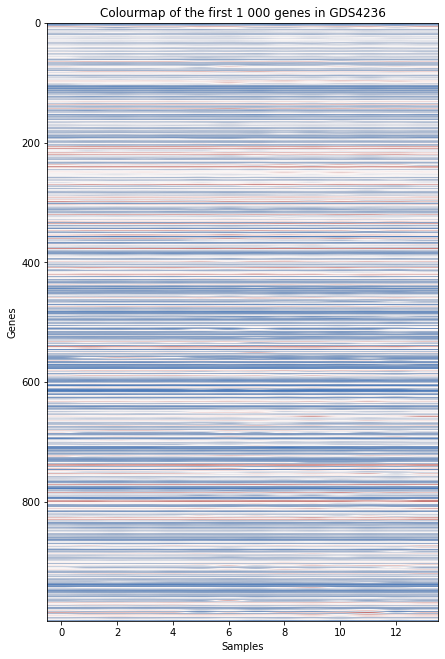

In [17]:
# show colourmap of first 1 000 entries

plt.figure(figsize = (7, 11))
plt.imshow(entry_rows, aspect = 'auto', cmap = 'vlag')
plt.title("Colourmap of the first 1 000 genes in GDS4236")
plt.xlabel('Samples')
plt.ylabel('Genes')
plt.show()

We can see from the image that the expression of the genes looks quite uniform across the samples. Our goal in this section will be to bicluster both genes and samples in order to find out whether there is hidden checkerboard structure in our dataset. For that purpose, we must select appropriate genes. Because most of the genes are with quite uniform expression across the samples, we will select those which are differentialy expressed. 

In order to do that, we will opt for genes with variance higher than 1.5 across the cell lines. Let's take a look.

In [18]:
geo_data[geo_data.iloc[:].std(axis = 1) > 1.5]

,GSM673825,GSM673826,GSM673827,GSM673828,GSM673829,GSM673830,GSM673832,GSM673836,GSM673838,GSM673831,GSM673837,GSM673833,GSM673834,GSM673835
IDENTIFIER,,,,,,,,,,,,,,
RAVER2,5.07734,4.23213,4.00007,4.15550,4.03008,8.55944,4.16740,8.23493,4.25176,4.41823,4.14373,4.07016,7.96164,8.47619
IFI44L,4.24149,9.35582,11.55490,10.84110,9.34313,4.13564,5.02967,3.76162,3.99710,4.60629,4.18055,6.00985,4.07966,3.98324
IFI44,3.56814,6.71287,8.72423,7.34750,6.40002,5.78302,3.58472,5.76864,2.86959,4.55025,3.01134,7.48771,2.97054,3.11728
FNBP1L,3.72633,3.80877,3.64850,3.53997,3.47339,6.90085,3.38396,7.76237,5.01242,3.49254,3.52929,3.62782,3.89671,6.86160
KIAA1324,5.57833,4.51613,4.63984,4.94172,4.36687,4.87605,4.73406,3.99734,5.70459,9.06985,4.86220,4.66859,5.06313,10.03640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DDX3Y,9.22117,5.10423,4.24096,4.11834,4.18552,4.25896,4.26400,9.80429,4.22169,4.54306,9.17155,4.25064,9.43668,4.11046
EIF1AY,10.78410,10.89170,10.73130,10.51330,10.84780,4.97798,4.53608,10.11970,4.48369,5.33560,10.43490,4.87759,10.41100,4.50384
UTY,7.42946,4.22738,3.81473,3.79912,3.81988,3.93478,3.95260,7.32904,3.72278,3.74454,6.85037,4.02222,7.77628,3.96122


400 genes and loci, excellent. From this time onward, these will be our working `geo_data`. 

In [19]:
# select genes with variance > 1.5

geo_data = geo_data[geo_data.iloc[:].std(axis = 1) > 1.5]

Let's desplay an image of these 400 genes and see how they look like. 

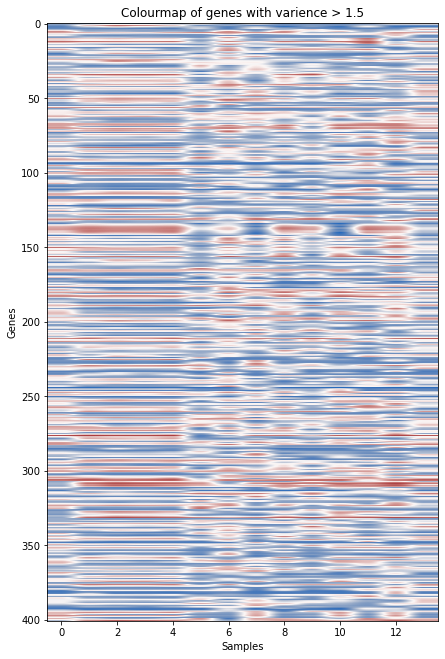

In [20]:
# display colourmap image of genes with varience > 1.5

plt.figure(figsize = (7, 11))
plt.imshow(geo_data, aspect = 'auto', cmap = 'vlag')
plt.title("Colourmap of genes with varience > 1.5")
plt.xlabel('Samples')
plt.ylabel('Genes')
plt.show()

Ok, they look much more shuffled. Now, we will bicluster these genes and samples, however, we will first scale them to zero mean and unit variance by using the scikit learn module `StandardScaler`. We do this in order to be able to compare this scaled version of our selected genes with their native RMA value form later on in this section. 

In [21]:
# scale the data

geo_data_scaled = StandardScaler().fit_transform(geo_data)

In [22]:
# transform scaled data to pd.DataFrame

geo_data_scaled = pd.DataFrame(geo_data_scaled, columns = geo_data.columns, index = geo_data.index)

In [23]:
geo_data_scaled

,GSM673825,GSM673826,GSM673827,GSM673828,GSM673829,GSM673830,GSM673832,GSM673836,GSM673838,GSM673831,GSM673837,GSM673833,GSM673834,GSM673835
IDENTIFIER,,,,,,,,,,,,,,
RAVER2,-0.804746,-1.112653,-1.138609,-1.050985,-1.100753,0.981032,-1.235689,0.655716,-1.017029,-0.836919,-1.068285,-1.054568,0.424390,0.819857
IFI44L,-1.172906,1.036467,1.830405,1.648358,1.002074,-0.978993,-0.868648,-1.213502,-1.124194,-0.751693,-1.052948,-0.259930,-1.157065,-1.227665
IFI44,-1.469491,-0.072112,0.717965,0.237800,-0.162766,-0.249098,-1.483717,-0.374848,-1.598668,-0.777089,-1.539982,0.345509,-1.608902,-1.622300
FNBP1L,-1.399814,-1.290231,-1.276774,-1.299508,-1.321083,0.246171,-1.569174,0.458252,-0.696931,-1.256429,-1.324230,-1.235783,-1.231596,0.084058
KIAA1324,-0.584079,-0.993530,-0.887182,-0.733545,-0.967457,-0.650944,-0.994480,-1.115004,-0.405655,1.271130,-0.769007,-0.809408,-0.756416,1.530875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DDX3Y,1.020453,-0.746853,-1.043940,-1.065989,-1.039232,-0.924354,-1.194569,1.311489,-1.029683,-0.780348,1.026054,-0.980631,1.025297,-1.169689
EIF1AY,1.708864,1.680689,1.506734,1.516007,1.597600,-0.605782,-1.078753,1.443286,-0.919429,-0.421180,1.552302,-0.723786,1.422219,-0.990418
UTY,0.231273,-1.114645,-1.211447,-1.194875,-1.183947,-1.067987,-1.327122,0.277181,-1.239632,-1.142226,0.059166,-1.074208,0.348877,-1.237700


Now, let's define our first function which will bicluster our data. In addition to our data, we will include two other parameters. Because the scikit learn algorithm `SpectralBiclustering` partitions rows and columns under the assumption that the data has an underlying checkerboard structure, we should provide the number of row and column clusters for which the algorithm to search for, as well as the method of normalization. The method may be one of 'scale', 'bistochastic', or 'log'. By default it is used 'bistochastic'.

In [24]:
def spectral_biclustering(data, n_clusters = None, method = None):
    """
    Partitions rows and columns under the assumption that the data 
    has an underlying checkerboard structure
    """
    model = SpectralBiclustering(n_clusters = n_clusters, method = method, n_components = 6,
                                 svd_method = 'randomized',
                                 random_state = 0)

    model.fit(data)
    
    return model

Let's use our scaled data to create a model. 

In [25]:
scaled_model = spectral_biclustering(geo_data_scaled, n_clusters = (4, 4), method = 'log')

In [26]:
scaled_model

SpectralBiclustering(method='log', n_clusters=(4, 4), random_state=0)

Now, since we obtained our model of the scaled data, we can examine how the algorithm partitioned the rows (genes) and columns (samples) by using `column_labels_` and `row_labels_` attributes.

Let's see.

In [27]:
scaled_model.column_labels_

array([3, 1, 1, 1, 1, 2, 0, 2, 3, 2, 3, 3, 0, 2])

In [28]:
scaled_model.row_labels_

array([2, 1, 1, 2, 2, 0, 2, 0, 0, 3, 3, 3, 3, 0, 0, 1, 0, 0, 0, 1, 1, 2,
       2, 3, 3, 1, 1, 2, 2, 2, 1, 2, 3, 2, 3, 1, 0, 3, 3, 3, 3, 1, 2, 1,
       1, 2, 2, 2, 1, 1, 3, 1, 3, 1, 3, 2, 1, 1, 0, 3, 2, 2, 3, 0, 2, 2,
       2, 3, 3, 0, 0, 1, 3, 2, 3, 3, 3, 3, 0, 0, 0, 2, 2, 1, 0, 3, 3, 2,
       3, 2, 2, 3, 1, 0, 0, 0, 1, 0, 3, 1, 1, 1, 2, 1, 2, 0, 3, 0, 2, 2,
       2, 0, 3, 1, 3, 3, 2, 2, 1, 3, 1, 0, 2, 2, 1, 2, 2, 1, 1, 0, 2, 1,
       0, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 0, 3, 2, 0, 2, 3, 3, 1, 3, 2,
       3, 0, 3, 0, 1, 3, 3, 1, 0, 2, 2, 1, 1, 0, 2, 2, 3, 1, 2, 0, 0, 3,
       2, 0, 0, 2, 3, 0, 3, 3, 3, 2, 0, 0, 0, 1, 0, 0, 2, 0, 0, 3, 0, 1,
       2, 3, 1, 2, 3, 2, 1, 2, 1, 0, 2, 0, 1, 2, 2, 3, 0, 2, 1, 1, 2, 0,
       0, 1, 0, 3, 2, 1, 2, 2, 2, 1, 1, 2, 2, 0, 3, 1, 0, 2, 3, 1, 1, 1,
       0, 0, 2, 1, 0, 3, 1, 3, 2, 0, 1, 3, 0, 2, 0, 3, 3, 3, 1, 2, 0, 0,
       3, 2, 1, 1, 2, 2, 1, 3, 3, 1, 0, 3, 3, 3, 1, 3, 2, 1, 0, 2, 0, 1,
       2, 2, 1, 2, 1, 0, 1, 1, 1, 2, 0, 3, 3, 0, 1,

Now, after we got our row and column partitioning labels, we should sort and reorder them so that we can visualize our model in order to inspect whether the dataset has checkerboardlike structure. Hence, we will define function `visualize_model`, which creates clustermap of the reordered row and column labels according to the model, and plots horizontal and vertical lines separating these row and column labels for better visualization.

Let's define that function.

In [29]:
def visualize_model(model, data, n_clusters):
    """
    Reorders row and column labels and plot cluster map with lines separating defferent biclusters
    """
    # reorder rows
    new_order_row = [list(row) for row in zip(model.row_labels_, data.index)]
    new_order_row.sort(key = lambda k: (k[0], k[1]))
    ordered_row = [i[1] for i in new_order_row]

    # reorder columns
    new_order_col = [list(col) for col in zip(model.column_labels_, data.columns)]
    new_order_col.sort(key = lambda k: (k[0], k[1]))
    ordered_col = [i[1] for i in new_order_col]

    # reorder data matrix
    data_reordered = data.reindex(index = ordered_row)  # rows
    data_reordered = data.reindex(columns = ordered_col)  # columns

    # use clustermap
    cluster_map = sns.clustermap(data_reordered, figsize = (9, 16), cmap = 'vlag')
    ax = cluster_map.ax_heatmap

    # plot lines for different clusters
    hor_lines = [sum(item) for item in model.biclusters_[0]]
    hor_lines = list(np.cumsum(hor_lines[::n_clusters[1]]))
    
    ver_lines = [sum(item) for item in model.biclusters_[1]]
    ver_lines = list(np.cumsum(ver_lines[:n_clusters[0]]))
    
    for l in range(len(hor_lines) - 1):
        ax.hlines(hor_lines[l], 0, data.shape[1], colors = 'r')
    
    for l in range(len(ver_lines) - 1):
        ax.vlines(ver_lines[l], 0, data.shape[0], colors = 'r')
    
    plt.show()

Ok, because we already have this function, let's indeed visualize our model.

Let's take a look.

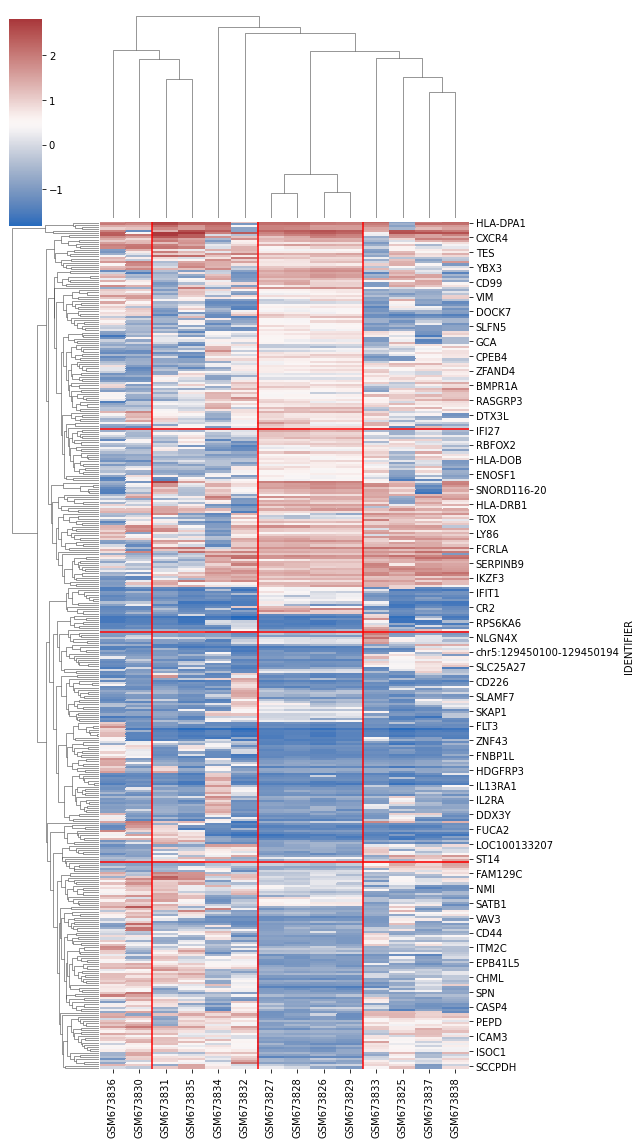

In [30]:
visualize_model(scaled_model, geo_data_scaled, n_clusters = (4, 4))

Ok, we obtained some results, although it is difficult to interpret them at this point. Firstly, the subset of genes looks much more ordered with respect to differential expression. Down-regulated genes (denoted with blue bars on the map) seem to be clustered together across subset of sampples, the same applies for up-regulated genes. However, no one can varify whether these are the correct biclusters. If we select different combinations of `n_clusters` and `method` of normalization, we will obtain different result which mostly depends on the number of clusters. However, we will not do that, rather we will compare the scaled data with the original one. 

For that purpose, let's create yet another model with the native RMA values.   

In [31]:
not_scaled_model = spectral_biclustering(geo_data, n_clusters = (4, 4), method = 'log')

In [32]:
not_scaled_model

SpectralBiclustering(method='log', n_clusters=(4, 4), random_state=0)

Now, let's visualize this model and see what we get. 

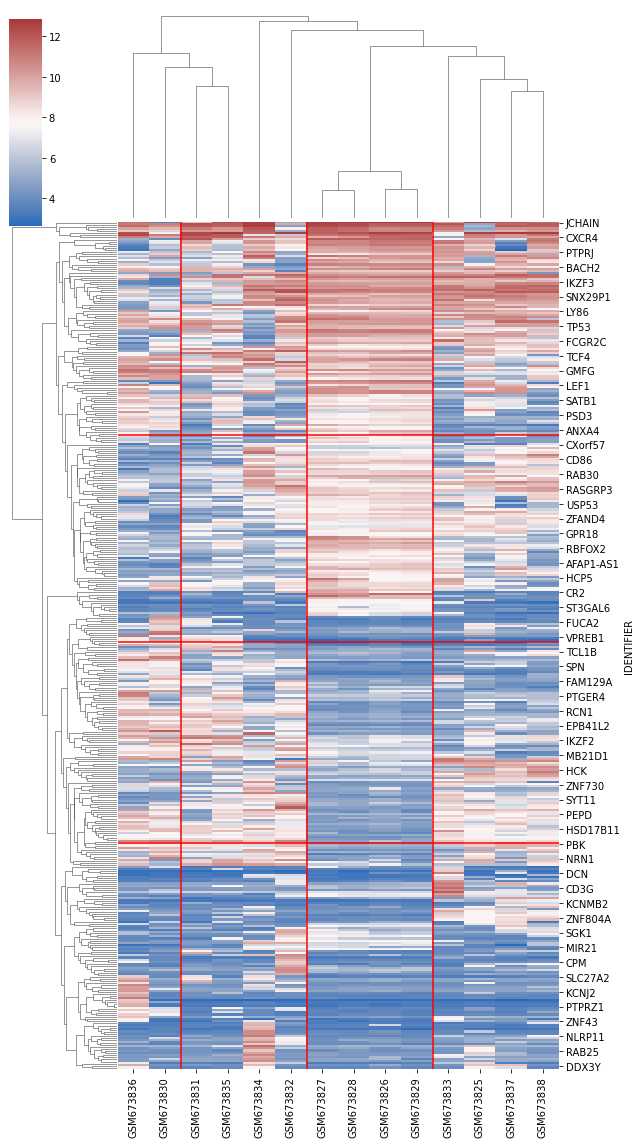

In [33]:
visualize_model(not_scaled_model, geo_data, n_clusters = (4, 4))

It looks by some means differently. Since, however, we can not inspect by eye every line and every column to say where are the difference, scikit learn offers for us module to evaluate computationally the similarities between different biclusters in our scaled and native model.  

`consensus_score` implements the Jaccard index in order to compare a set of found biclusters in both models. This algorithm assign biclusters from one set to another in a one-to-one fashion to maximize the sum of their similarities. Finally, the sum of similarities is divided by the size of the larger set. The minimum consensus score, 0, occurs when all pairs of biclusters are totally dissimilar. The maximum score, 1, occurs when both sets are identical.

Let's take a look.

In [34]:
# evaluate similarities between both models

score = consensus_score(scaled_model.biclusters_, not_scaled_model.biclusters_)
print(f'Consensus score: {score}')

Consensus score: 0.9227243505641565


68% similarity between our scaled and native models. If we play around with the number of biclusters when creating the models, this percentage will be different. Although, we hardly could know which is the best (true) solution, because when working with real data the true solution is usually unknown. However, we could do something else. When working with real data the true solution may be unknown, but biclustering artificial data may be useful for evaluating algorithms precisely because the true solution is known. Therefore, we will create synthetic checkerboard data by using the scikit learn module `make_checkerboard`. Then we will bicluster that data by using `SpectralBiclustering` algorithm, and eventually we will visualize that model by using our `visualize_model` function in order to find out whether this sequence of algorithms can create, shuffle, reorder, and visualize checkerboardlike data.

Let's do that. First, we will define function that create, shuffle, and scale synthetic checkerboard data.

In [35]:
def synthetic_checkerboard_data(shape, n_clusters):
    """
    Create, shuffle, and scale synthetic checkerboard data
    """
    # create and shuffle data
    data, rows, columns = make_checkerboard(
        shape = shape, n_clusters = n_clusters, noise = 10,
        shuffle = True, random_state = 1)

    # scale data
    synt_data = StandardScaler().fit_transform(data)
    
    # make pd.DataFrame
    data = pd.DataFrame(synt_data)
    
    return data

Now, after we got our function let's create syntetic data with the same dimensions as our original one - 401 rows × 14 columns.

In [36]:
synthetic_data = synthetic_checkerboard_data(shape = (401, 14), n_clusters = (4, 4))

In [37]:
synthetic_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-1.869718,-0.542105,0.246313,0.732642,-0.499251,1.201996,-1.737165,-1.232547,-0.204861,-0.229830,0.992635,0.191773,0.353097,0.663425
1,0.703162,0.103147,0.424944,1.137684,0.537711,1.410360,0.525803,1.066113,0.813151,1.202044,0.683441,1.720259,0.849517,1.447147
2,0.048249,0.988928,0.608292,0.701585,1.127373,1.807013,-0.550604,0.713850,1.347675,0.170856,0.987499,0.775149,1.216222,0.927445
3,-1.985259,-0.436851,0.625536,0.793767,-0.161645,1.070404,-0.200396,-0.274465,-0.683577,-1.500475,0.854779,0.008072,-0.866774,0.171014
4,-0.000669,-1.145974,0.761459,0.660708,-1.996030,-0.640951,0.477244,-1.288882,-1.388465,1.022974,0.727315,-0.903734,-0.914385,0.094191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,-0.567092,0.444077,-1.438162,-1.469767,0.095254,-0.449075,-1.138531,0.910319,0.172955,-0.670687,-0.927275,-0.616665,0.486342,-1.244583
397,0.859725,-1.419624,0.973056,0.463502,-0.853142,0.016356,0.824676,-1.780110,-1.267399,0.455748,0.113816,-1.621582,-1.407841,1.305051
398,0.587622,1.942002,0.832888,0.631529,0.825703,0.613602,0.947745,0.938039,1.663654,1.106517,0.251675,1.610312,0.873440,0.018055
399,-1.376822,0.504640,-1.531115,-1.123417,1.360091,-1.439793,-1.651686,0.802821,0.036666,-0.085934,-1.079511,-0.930164,0.517953,-2.229966


We can visualize these values for better interpretation.

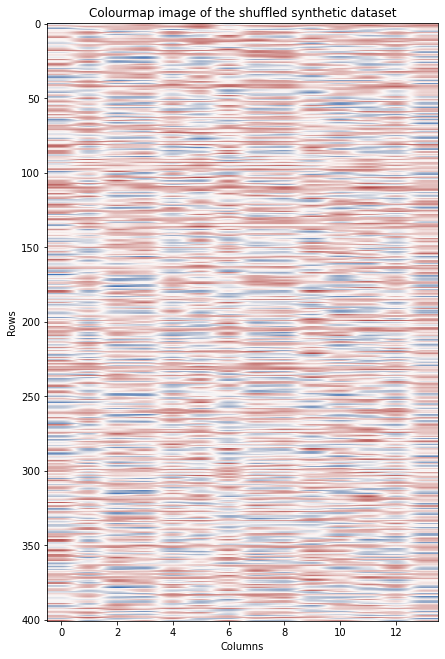

In [38]:
# display colourmap image of synthetic data 

plt.figure(figsize = (7, 11))
plt.imshow(synthetic_data, aspect = 'auto', cmap = 'vlag')
plt.title("Colourmap image of the shuffled synthetic dataset")
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

This dataset looks well shuffled. Now, let's use our `spectral_biclustering` function to create our synthetic model with the same arguments as our original ones.  

In [39]:
synthetic_model = spectral_biclustering(synthetic_data, n_clusters = (4, 4), method = 'log')

In [40]:
synthetic_model

SpectralBiclustering(method='log', n_clusters=(4, 4), random_state=0)

Now, we can use `visualize_model` to verify whether our synthetic data has checkerboardlike structure. 

Let's see.

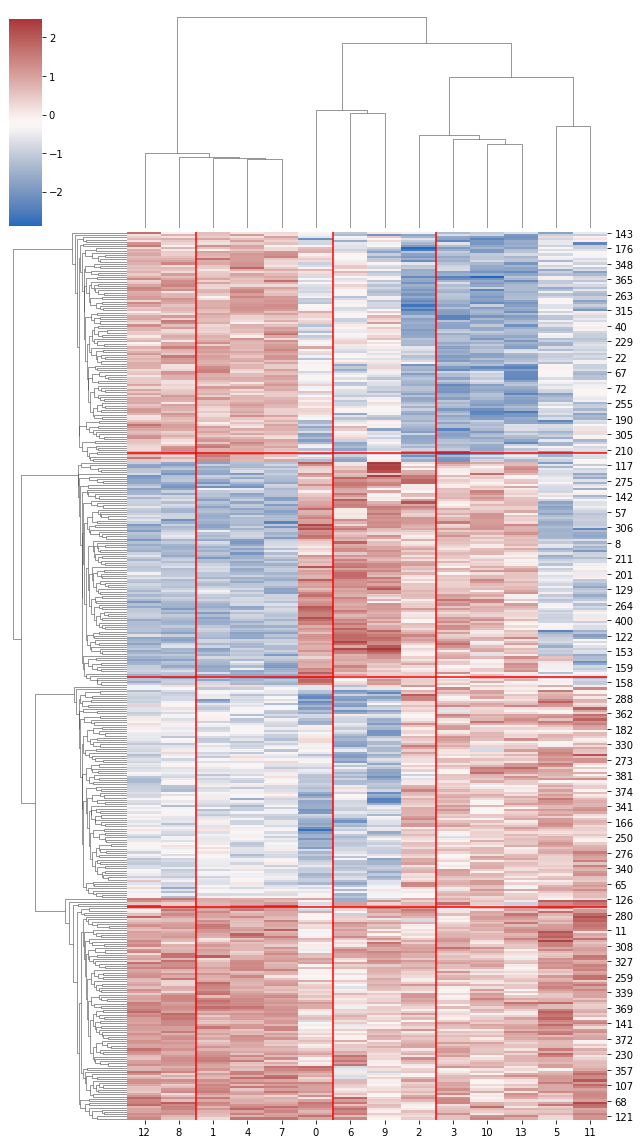

In [41]:
visualize_model(synthetic_model, synthetic_data, n_clusters = (4, 4))

Well, it looks like the scikit learn algorithm `SpectralBiclustering` succeeded to recover a hidden checkerboard structure, at least to some extent. Though, if one plays a bit around with, for example, `random state`, or tries to use another shuffling method, one will observe that the algorithm can recover hidden checkerboard structure with varying success. This issue may not arise from the very algorithm, but rather from our plotting function. If we use, for example, different `random state` in our `synthetic_checkerboard_data` function we will observe that the separating lines defined in the plotting function go in totally different directions, which implies that this plotting function must be further optimized. Nevertheless, this project aims not to provide some qualitative result, but rather it is done with trainig purpose.  

### IV. Discussion

This project focuses on one particular unsupervised machine learning algorithm named spectral biclustering. Unsupervised methods are useful when labels of the data are unavailable. In microarrays context, unsupervised clustering of genes and experimental conditions can potentially reveal co-regulated genes, thus suggesting for common function of these genes. Subsequently, these findings can provide labels for supervised machine learning techniques. 

The method of spectral biclustering utilizes the information gained by clustering the genes to facilitate the clustering of conditions, and vice versa. This approach relies on closely integrated normalization steps. Specifically, the spectral biclustering algorithm is developed to cluster genes and conditions under the assumption that hidden checkerboardlike sctructure could exist in a microarray gene expression matrix. This checkerboardlike structure can reveal markedly up- and down-regulated genes across a subset of conditions, thus inferring for common regulation and even function of these genes. In cancer contex, these coregulated genes can be used as markers for classification of certain types of tumors. 

Although, the results obtained in the project are not perfect, they indicate that the scikit learn algorithm `SpectralBiclustering` can be used successfully to unveil checkerboardlike structure in artificially created dataset with hidden checkerboard pattern, and to group genes with similar expression across a subset of conditions in real dataset. As future challenge, the functions generated in the project must be further optimized and improved, especially with respect to separating plotting lines. 

### V. Glossary

_**ChiP-on-chip**_ - a technology that combines chromatin immunoprecipitation ('ChIP') with DNA microarray ("chip"). It is mainly used to investigate the interaction between proteins and DNA with the aid of microarrays.

_**Copy-number variations (CNVs)**_ - a phenomenon in which sections of the genome are repeated and the number of repeats in the genome varies between individuals. 

_**Expressed sequence tags (ESTs)**_ - a unique stretch of DNA within a coding region of a gene that is useful for identifying full-length genes and serves as a landmark for mapping. ESTs may also be used to identify gene transcripts, and are instrumental in gene discovery and in gene-sequence determination.

_**Functional genomics**_ - a field of molecular biology that attempts to describe gene (and protein) functions and interactions. Functional genomics focuses on the dynamic aspects such as gene transcription, translation, regulation of gene expression and protein–protein interactions, as opposed to the static aspects of the genomic information such as DNA sequence or structures. A key characteristic of functional genomics studies is their genome-wide approach to these questions, generally involving high-throughput methods rather than a more traditional “gene-by-gene” approach. 

_**Next-generation sequencing (NGS)**_ - also known as high-throughput sequencing, is the catch-all term used to describe a number of different modern sequencing technologies. These technologies allow for sequencing of DNA and RNA much more quickly and cheaply than the previously used Sanger sequencing, and as such revolutionised the study of genomics and molecular biology. Such technologies include: Illumina (Solexa) sequencing, Roche 454 sequencing, Ion Torrent: Proton / PGM sequencing, and SOLiD sequencing. 

_**Probes**_ - a short DNA sequences arranged on microarray spot which target a specific region of a gene transcript. They are used to detect the presence of nucleotide sequences through hybridisation to single-stranded nucleic acid due to complementarity between the probe and the target. Typically, probes are 25 bp to 60 bp long. In Affymetrix arrays, probes are grouped into probesets which are designed to target different regions in the same gene transcript, thus allowing for multiple measurements.

_**RNA-Seq**_ - the most recent transcriptomic approach where the total complement of RNAs from a given sample is isolated and sequenced using high-throughput technologies (most often next-generation sequencing).

_**Single-nucleotide polymorphisms (SNPs)**_ - the most common type of genetic variation among people. Each SNP represents a difference in a single DNA nucleotide. For example, at a specific base position in the human genome, the C nucleotide may appear in most individuals, but in a minority of individuals, the position is occupied by an A. This means that there is a SNP at this specific position, and the two possible nucleotide variations – C or A – are said to be the alleles for this specific position. 

_**Target**_ - a fluorescently labeled DNA, cDNA, or cRNA (also called anti-sense RNA) that are used to hybridize to the microarray probes under high-stringency conditions. Essentially, these molecules represent the sample of interest.

### VI. References

1. M. Madan Babu _et al._ 2004. Computational Genomics: Theory and Application. Chapter 11. An Introduction to Microarray Data Analysis. Publisher: Horizon Bioscience. 


2. Chandan K. Reddy, Charu C. Aggarwal, 2013. Data Clustering. Chapter 16. Clustering Biological Data. Publisher: Chapman and Hall/CRC.


3. Yuval Kluger, Ronen Basri, Joseph T. Chang, and Mark Gerstein, 2003. Spectral Biclustering of Microarray Data: Coclustering Genes and Conditions. Genome Research 13(4):703-16 May 2003. doi: 10.1101/gr.648603.


4. Beatriz Pontes, Raúl Giráldez, Jesús S. Aguilar-Ruiz, 2015. Biclustering on expression data: A review. Journal of Biomedical Informatics. 2015 Oct; 57:163-80. doi: 10.1016/j.jbi.2015.06.028.


5. Verónica Bolón-Canedo and Amparo Alonso-Betanzos, 2019. Microarray Bioinformatics. Methods in Molecular Biology. doi: 10.1007/978-1-4939-9442-7.


6. John Quackenbush, 2001. Computational Analysis of Microarray Data. Nat Rev Genet. 2001 Jun;2(6):418-27. doi: 10.1038/35076576. 